In [2]:
import pandas as pd
import matplotlib.pyplot as plt

DEBUG = True

In [3]:
# Define column names for BLAST data
BLAST_COLUMNS = [
    'ID', 'sseqid', 'pident', 'alignment_length', 'mismatches', 
    'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 
    'evalue', 'bit_score'
]

try:
    blast_df = pd.read_csv('combined_amr_gene_hits.txt', delimiter='\t', header=None)
    blast_df.columns = BLAST_COLUMNS
    if DEBUG:
        print(f"Loaded BLAST Data: {blast_df.shape[0]} rows, {blast_df.shape[1]} columns")
except FileNotFoundError:
    raise FileNotFoundError("BLAST output file 'combined_amr_gene_hits.txt' not found. Please check the file path.")

Loaded BLAST Data: 511 rows, 12 columns


In [4]:
# Filter for genes with >= 90% identity
filtered_df = blast_df[blast_df['pident'] >= 90].copy()
if DEBUG:
    print(f"Filtered Results: {filtered_df.shape[0]} rows remaining after filtering")


Filtered Results: 462 rows remaining after filtering


In [5]:
# Extract ARO_Index and Gene name from sseqid
filtered_df['ARO_Index'] = filtered_df['sseqid'].str.extract(r'(ARO:\d+)')
filtered_df['Gene'] = filtered_df['sseqid'].str.extract(r'\|ARO:\d+\|([^|]+)')

# Keep relevant columns
processed_df = filtered_df[['ID', 'ARO_Index', 'Gene', 'pident', 'alignment_length', 
                             'mismatches', 'gap_opens', 'q_start', 'q_end', 
                             's_start', 's_end', 'evalue', 'bit_score']]

# Save filtered and processd data to a new file
processed_df.to_csv('processed_amr_gene_hits.tsv', sep='\t', index=False)

In [ ]:
processed_df

,ID,ARO_Index,Gene,pident,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,U00096.3,ARO:3000833,evgS,100.000,3594,0,0,2484374,2487967,1,3594,0.000000e+00,6637
1,U00096.3,ARO:3000216,acrB,100.000,3150,0,0,481254,484403,3150,1,0.000000e+00,5818
3,U00096.3,ARO:3000793,mdtB,100.000,3123,0,0,2155263,2158385,1,3123,0.000000e+00,5768
4,U00096.3,ARO:3000491,acrD,100.000,3114,0,0,2587595,2590708,1,3114,0.000000e+00,5751
5,U00096.3,ARO:3000796,mdtF,100.000,3114,0,0,3660414,3663527,1,3114,0.000000e+00,5751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,CP024140.1,ARO:3000980,TEM-117,99.606,762,3,0,63687,64448,762,1,0.000000e+00,1391
504,CP024140.1,ARO:3001052,TEM-192,99.602,753,3,0,63702,64454,753,1,0.000000e+00,1375
506,CP024140.1,ARO:3002859,dfrA14,100.000,474,0,0,45703,46176,474,1,0.000000e+00,876
509,CP024140.1,ARO:3002578,AAC(6')-Ib7,100.000,210,0,0,46193,46402,210,1,6.320000e-106,388


# CLassifying AMR Gene

In [7]:
# Load reference tables
try:
    ref_df = pd.read_csv('aro_categories_index.tsv', delimiter='\t')
    ref2_df = pd.read_csv('aro_index.tsv', delimiter='\t')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Reference file not found: {e.filename}")

# Merge reference tables
ref2_df = ref2_df[['DNA Accession', 'CARD Short Name']]
merged_refs_df = pd.merge(ref_df, ref2_df, how='inner', on='DNA Accession')
merged_refs_df.shape


(16836, 6)

In [8]:
# Merge processed data with reference data
merged_ref_processed_df = pd.merge(processed_df, merged_refs_df, how='left', left_on='Gene', right_on='CARD Short Name')

# Remove NaN values and sort by AMR Gene Family
merged_ref_processed_df = merged_ref_processed_df.dropna()
merged_ref_processed_df = merged_ref_processed_df.sort_values(by=['AMR Gene Family'], ascending=True)

In [9]:
# Retain columns required, drop others
final_df = merged_ref_processed_df[['ID', 'AMR Gene Family', 'Drug Class', 'Gene']]

# Remove duplicates and save the final classified data
final_df = final_df.drop_duplicates()
final_df.rename(columns={'Gene': 'Gene Variant', 'Drug Class': 'Resistance Class'}, inplace=True)
final_df.to_excel('classified_amr_gene_hit.xlsx', index=False)
final_df.shape
# Check for missing data
missing_data_percentage = final_df.isnull().mean() * 100
missing_data_percentage


ID                  0.0
AMR Gene Family     0.0
Resistance Class    0.0
Gene Variant        0.0
dtype: float64

Histogram saved as 'pident_distribution.png'


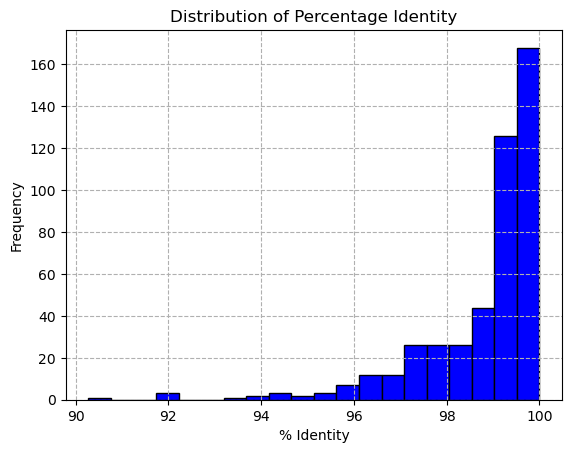

In [10]:
# Visualize Distribution of % identity
processed_df['pident'].hist(bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Percentage Identity')
plt.xlabel('% Identity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--')
plt.savefig('pident_distribution.png', dpi=300)
if DEBUG:
    print("Histogram saved as 'pident_distribution.png'")
plt.show()
